In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
from picsellia.client import Client

api_token = "f05f48d5d1ecbeabd17ead45c1383c6bf34759a9"
project_token = "fc516a5b-2000-4c3a-96a6-1f7e1f0eba94"
experiment_name = "test2"
clt = Client.Experiment(api_token, project_token=project_token)
exp = clt.checkout(name=experiment_name, with_file=True)


Hi pierre-nicolas, welcome back.
-----
==================================================]--*--
-----
==================================================]--*--


# Download the dataset and split the classes into different folders

In [4]:
exp.dl_annotations()
exp.dl_pictures()
exp.train_test_split()
train_split = {
    'x': exp.categories,
    'y': exp.train_repartition,
    'image_list': exp.train_list_id
}
exp.log('train-split', train_split, 'bar', replace=True)

test_split = {
    'x': exp.categories,
    'y': exp.test_repartition,
    'image_list': exp.eval_list_id
}
exp.log('test-split', test_split, 'bar', replace=True)



-----
[==================================================] 196/196--*--
Images downloaded
156 images used for training and 40 images used for validation


In [5]:
labels_index = [e for e in range(1, len(exp.categories)+1)]
labelmap = dict(zip(labels_index, exp.categories))
exp.log('labelmap', labelmap, 'labelmap', replace=True)


## We create all the directories from the image folder so we can create a dataset with Tensorflow utils easily

In [6]:
splits = ["train", "validation"]
for split in splits:
    if not split in os.listdir("images"):
        os.mkdir(f"images/{split}")
    for category in exp.categories:
        if not category in os.listdir(f"images/{split}"):
            os.mkdir(f"images/{split}/{category}")


## Now we will go through the list generated by the train_test_split() method and move the images to their corresponding directory

In [7]:
train_dir = "images/train"
validation_dir = "images/validation"

for train_img in exp.train_list:
    filename = train_img.split("/")[-1]
    label = filename.split("_")[0]
    os.rename(train_img, f"{train_dir}/{label}/{filename}")

for eval_img in exp.eval_list:
    filename = eval_img.split("/")[-1]
    label = filename.split("_")[0]
    os.rename(eval_img, f"{validation_dir}/{label}/{filename}")

In [8]:
parameters = exp.get_data("parameters")

In [9]:
BATCH_SIZE = parameters["batch_size"]
IMG_SIZE = (parameters["image_size"], parameters["image_size"])

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 156 files belonging to 3 classes.


In [10]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 40 files belonging to 3 classes.


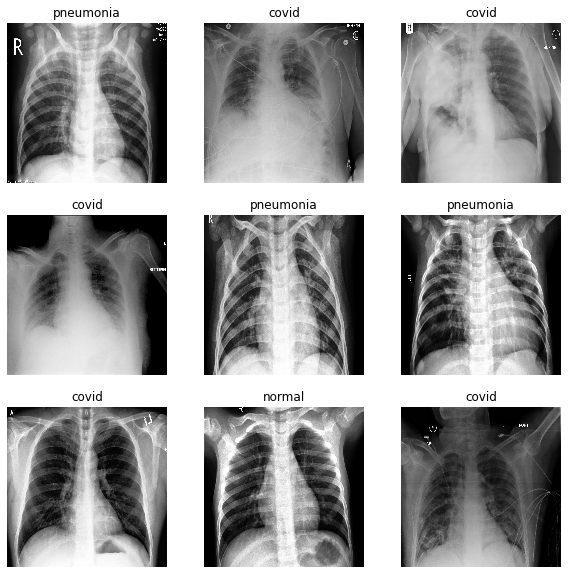

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 2
Number of test batches: 0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


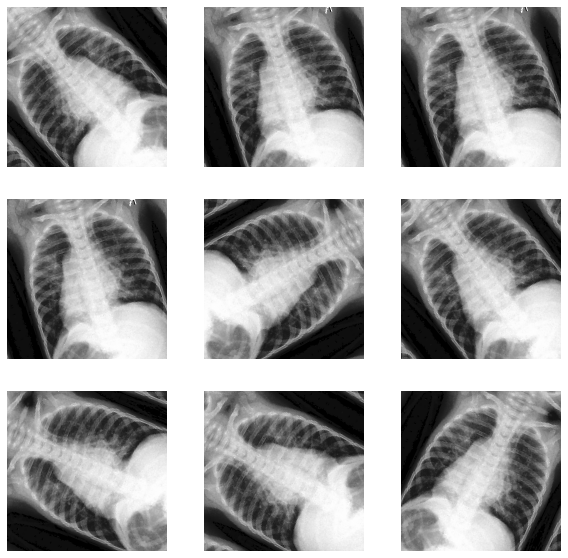

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = IMG_SIZE + (3,)



In [ ]:
from tensorflow.keras.callbacks import Callback

class PicselliaLogger(Callback):

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            exp.log(log_name, [float(log_value)], 'line')

callback_list = [PicselliaLogger()]

In [ ]:
fine_tune = parameters["fine_tune"]

# IF FINE_TUNE == FALSE (if it's the first time you train the model and the weights comes from the original model, not from a previous experiment where you have uploaded fine-tuned weights)

# Please see 13 cells below to train with fine-tuned weights

In [16]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=os.path.join(exp.base_dir, "model.h5"))


ValueError: You are trying to load a weight file containing 2 layers into a model with 104 layers.

In [17]:
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 5, 5, 1280)
(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(parameters["image_size"], parameters["image_size"], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


NameError: name 'base_model' is not defined

In [21]:


base_learning_rate = parameters["learning_rate"]
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [22]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
initial_epochs = parameters["initial_epochs"]

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=callback_list,
                    validation_data=validation_dataset)


2/2 [==============================] - 1s 56ms/step - loss: 7.1526e-08 - accuracy: 0.4000
initial loss: 0.00
initial accuracy: 0.40
Epoch 1/100
5/5 [==============================] - 5s 481ms/step - loss: 1.1233e-07 - accuracy: 0.3397 - val_loss: 7.1526e-08 - val_accuracy: 0.4000
Epoch 2/100
5/5 [==============================] - 3s 461ms/step - loss: 1.1233e-07 - accuracy: 0.3654 - val_loss: 7.1526e-08 - val_accuracy: 0.4000
Data successfully append
Data successfully append
Data successfully append
Epoch 3/100
Data successfully append
5/5 [==============================] - 3s 465ms/step - loss: 1.1233e-07 - accuracy: 0.3333 - val_loss: 7.1526e-08 - val_accuracy: 0.4000
Epoch 4/100
Data successfully append
Data successfully append
Data successfully append
Data successfully append
5/5 [==============================] - 3s 459ms/step - loss: 1.1233e-07 - accuracy: 0.3590 - val_loss: 7.1526e-08 - val_accuracy: 0.4000
Epoch 5/100
Data successfully append
Data successfully append
Data succe

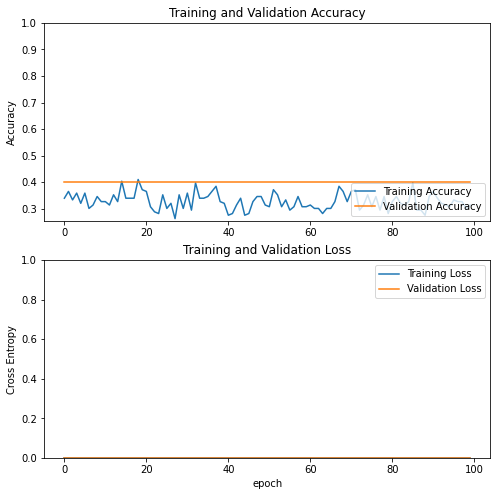

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [17]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


NameError: name 'base_model' is not defined

In [24]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
fine_tune_epochs = parameters["fine_tune_epochs"]
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callback_list,
                         validation_data=validation_dataset)


Epoch 11/20
5/5 [==============================] - 10s 802ms/step - loss: 1.1253e-07 - accuracy: 0.2909 - val_loss: 8.0466e-08 - val_accuracy: 0.4000
Data successfully append
Data successfully append
Data successfully append
Epoch 12/20
Data successfully append
5/5 [==============================] - 4s 560ms/step - loss: 1.0756e-07 - accuracy: 0.3407 - val_loss: 8.0466e-08 - val_accuracy: 0.4000
Epoch 13/20
Data successfully append
Data successfully append
Data successfully append
Data successfully append
5/5 [==============================] - 4s 562ms/step - loss: 1.0891e-07 - accuracy: 0.3672 - val_loss: 8.0466e-08 - val_accuracy: 0.4000
Epoch 14/20
Data successfully append
Data successfully append
Data successfully append
Data successfully append
5/5 [==============================] - 4s 558ms/step - loss: 1.0969e-07 - accuracy: 0.2737 - val_loss: 8.0466e-08 - val_accuracy: 0.4000
Epoch 15/20
Data successfully append
Data successfully append
Data successfully append
Data successfull

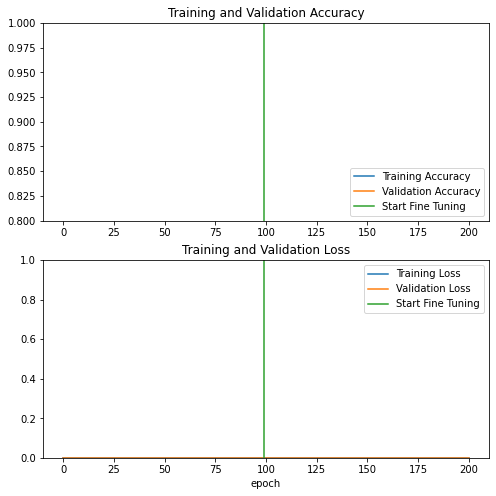

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# IF FINE_TUNE == TRUE (if you are using fine-tuned weights from a previous experiment for example)

In [ ]:
model = models.load_model(os.path.join(exp.base_dir, "model.h5"))
history_fine = model.fit(train_dataset,
                        epochs=parameters["fine_tune_epochs"],
                        initial_epoch=0,
                        callbacks=callback_list,
                        validation_data=validation_dataset)

In [77]:
models_dir = os.path.join(exp.base_dir, 'models')
#tf.saved_model.save(model, os.path.join(models_dir, 'saved_model'))
#model.save(os.path.join(models_dir, 'keras_model/model.h5'))
exp.store("keras_model", os.path.join(models_dir, 'keras_model/model.h5'))
exp.store("model-latest", os.path.join(models_dir, 'saved_model'), zip=True)

=========================                         ]

'9a0ab2a7-5414-46b7-b606-6398e54d17ab/0/saved_model.zip'

In [ ]:
y_true = []
y_pred = []
for btc in range(len(test_dataset)):
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    y_true.extend(image_batch)
    y_pred.extend(predictions.numpy())

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print('----------------')
print(confusion_matrix(y_true, y_pred))
print()
print('Classification Report')
print('---------------------')
print(classification_report(y_true, y_pred, target_names=exp.categories))
cm = {
    'categories': exp.categories,
    'values': confusion_matrix(y_true, y_pred).tolist()
}
exp.log('confusion-matrix', cm, 'heatmap')

Confusion Matrix
----------------
[[11 30  0]
 [ 8  3  0]
 [ 3 10  0]]

Classification Report
---------------------
              precision    recall  f1-score   support

       covid       0.50      0.27      0.35        41
      normal       0.07      0.27      0.11        11
   pneumonia       0.00      0.00      0.00        13

    accuracy                           0.22        65
   macro avg       0.19      0.18      0.15        65
weighted avg       0.33      0.22      0.24        65



/home/pn/.virtualenvs/picsellia/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
parameters["fine_tune"] = True
exp.log("parameters", parameters, "table", replace=True)
exp.update(status="success")

{'base_experiment': None,
 'base_model': {'checkpoint_object_name': '',
  'description': 'This is a real game changer',
  'files': {'keras_model': '8a961129-4ac1-4dcf-bea9-1b63ca8bd9d0/model.h5'},
  'framework': 'tensorflow2',
  'model_id': '8a961129-4ac1-4dcf-bea9-1b63ca8bd9d0',
  'model_object_name': '',
  'network_name': 'mobilenet_v2_classif_160',
  'organization': {'name': 'pierre-nicolas'},
  'origin_checkpoint_objects': {},
  'owner': {'username': 'pierre-nicolas'},
  'private': False,
  'tag': None,
  'thumb_object_name': '',
  'type': 'classification'},
 'data': [{'date_created': '2021-09-28T15:37:08.182769Z',
   'id': 14178,
   'last_update': '2021-09-28T15:37:08.182444Z',
   'name': 'labelmap',
   'type': 'labelmap'},
  {'date_created': '2021-09-28T15:37:08.213950Z',
   'id': 14179,
   'last_update': '2021-09-28T15:37:08.213573Z',
   'name': 'parameters',
   'type': 'table'},
  {'date_created': '2021-09-28T15:38:37.582433Z',
   'id': 14180,
   'last_update': '2021-09-28T15:3